# Outline

- create a model that predicts the category of each article by Neural Network
- train data is `matichon.json` that contains about 17K articles of Thai news by Matichon between 2015-2018
- X is `headline`
- y is category (10 labels)

# Import

In [26]:
import pandas as pd
import numpy as np
import re, collections

from tensorflow.keras.layers import Dense, Input, Embedding, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, to_categorical, pad_sequences

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from pythainlp.tokenize import word_tokenize

- custom tokenization function
- remove all quatations and shrink newlines `\n` and white spaces 
- input is tokenized sentence (list of str)

In [29]:
def my_tokenize(text):
    text = re.sub(r'[\"\']', '', text) # remove quotations
    text = re.sub(r'[\n\t\s]', ' ', text) # shrink newlines/spaces/tabs
    tokens = word_tokenize(text, keep_whitespace=True)
    return tokens + ['<END>']

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [30]:
df = pd.read_json('data/matichon.json')
df

,headline,article,date,category,url,id
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,2015-12-04 03:35:18,foreign,https://www.matichon.co.th/foreign/news_293,293
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",2015-12-04 04:10:49,politics,https://www.matichon.co.th/politics/news_329,329
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,2015-12-04 06:30:11,entertainment,https://www.matichon.co.th/entertainment/news_375,375
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,2015-12-04 07:10:26,entertainment,https://www.matichon.co.th/entertainment/news_393,393
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,2015-12-05 05:26:20,entertainment,https://www.matichon.co.th/entertainment/news_445,445
...,...,...,...,...,...,...
17104,โบว์ ณัฏฐา แจ้งความ พล.ต.อ.ศรีวราห์ ถูกพาดพิง...,เมื่อวันที่ 5 ก.ค. ที่ สน.พญาไท น.ส.ณัฏฐา มหัท...,2018-07-05 13:25:45,politics,https://www.matichon.co.th/politics/news_1029607,1029607
17105,ภาพบรรยากาศ ขุดทางระบายน้ำ เร่งนำ 13 ชีวิตออกจ...,วันที่ 5 กรกฎาคม เจ้าหน้าที่ขุดทางระบายน้ำที่ด...,2018-07-05 13:33:10,region,https://www.matichon.co.th/region/news_1029619,1029619
17106,สนช.ผ่านพ.ร.บ.สงฆ์ 3 วาระรวด พระมหากษัตริย์ทรง...,"สนช.ผ่าน พ.ร.บ.สงฆ์ 3 วาระรวด ""วิษณุ"" แจงสาระส...",2018-07-05 13:33:27,politics,https://www.matichon.co.th/politics/news_1029636,1029636
17107,นานาทรรศนะเพิ่มค่าปรับหมอ 5ล้านบ. สกัดเบี้ยว...,หมายเหตุ – จากกรณีที่ กระทรวงศึกษาธิการ (ศธ.) ...,2018-07-05 13:53:26,education,https://www.matichon.co.th/education/news_1029668,1029668


In [31]:
## drop "date", "article", "url", and "id"
df = df.drop(columns=['date','article','url','id'])
df.head()

,headline,category
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,foreign
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...",politics
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",entertainment
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",entertainment
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",entertainment


In [32]:
## value counts of target variable
df.category.value_counts()

politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: category, dtype: int64

# Tokenize & train-test split

- it may take more than 2 minutes
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`

In [33]:
df['tokens'] = df['headline'].apply(my_tokenize)

In [34]:
df.head()

,headline,category,tokens
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,foreign,"[ซาอุฯ, จ่อ, เปิดไฟเขียว, ให้, สิทธิ, หญิง, ม่..."
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...",politics,"[ไก่อู, ชี้, , ตู่, -, เต้น, , ไม่, ได้, มี,..."
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",entertainment,"[เปิดใจ, , โบว์, , แวนดา, , ระหว่าง, รอ, ยิ..."
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",entertainment,"[นาย, , ณ, ภัทร, , ปลื้ม, คน, ชม, แชมป์, ขึ้..."
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",entertainment,"[คอ, แทบ, หัก, !, , แม่ยก, แห่, คล้อง, พวงมาล..."


In [35]:
train, test = train_test_split(df, test_size=0.15, random_state=42) # same split as Logistic Regression

print(train.shape)
print(test.shape)

(14542, 3)
(2567, 3)


In [36]:
## min & max length of tokens
print('Min Length:', df.tokens.apply(len).min())
print('Max Length:', df.tokens.apply(len).max())

6 161


# Create Index Dictionary


in order to inverse numeric output label `1` into string category `economy`

~~~python
label_2_index = {'crime':0, 'economy':1, ...}
index_2_label = {0:'crime', 1:'economy', ...}
~~~

In [11]:
label_2_index = {label:i for i, label in enumerate(sorted(df.category.unique()))}
index_2_label = {v:k for k,v in label_2_index.items()}

- also, create dictionary for vocabs
- prepare index for `padding`, `start`, `end` beforehand

In [37]:
vocab_2_index = {'<PADDING>':0, '<END>':1}

## iterate each token in each headline
for tokens in df['tokens']:
    for token in set(tokens):
        if token not in vocab_2_index:
            vocab_2_index[token] = len(vocab_2_index) # if dict has 2 items, next index is 2
            
len(vocab_2_index)

19047

# create `X` and `y`

- indexing and padding
- max input length = 161

In [39]:
maxlen = 161

## indexing each word
## X must be 2D array e.g. [[1,46,5,20,...,2], [1,23,78,...,2], ]
X_train = [[vocab_2_index[token] for token in tokens] for tokens in train['tokens']]
X_test = [[vocab_2_index[token] for token in tokens] for tokens in test['tokens']]

## padding
X_train = pad_sequences(X_train, maxlen=maxlen, padding='post')
X_test = pad_sequences(X_test, maxlen=maxlen, padding='post')

## make y 
## 1. to index
## 2. one-hot-encoding e.g. [[0,1,0,0...], [0,0,0,1,...], ]
y_train = [label_2_index[label] for label in train['category']]
y_train = to_categorical(y_train, num_classes=len(label_2_index))
y_test = test['category'] # not need to index

print('TRAIN:', X_train.shape, y_train.shape)
print('TEST :', X_test.shape, y_test.shape)

TRAIN: (14542, 161) (14542, 10)
TEST : (2567, 161) (2567,)


In [40]:
X_train[0]

array([ 1935,   270,    15,  2390, 12877,  2245,  2794,  2893,  3436,
        1940,    80,  1000,    15,  4565,  3435,   187,   501,   436,
           1,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

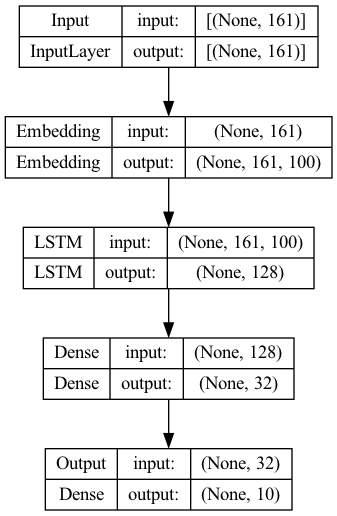

In [43]:
## instantiate each layer (functional API) 
input_layer = Input(shape=(maxlen,), name='Input')
embedding = Embedding(input_dim=len(vocab_2_index),
                      input_length=maxlen,
                      output_dim=100,
                      mask_zero=True,
                      name = 'Embedding')
lstm = LSTM(units=128,
            return_sequences=False,
            return_state=False,
        
            recurrent_dropout=0.2,
            name='LSTM')
dense = Dense(32, activation='relu', name='Dense')
output_layer = Dense(len(label_2_index), activation='softmax', name='Output')

## build model
x = embedding(input_layer)
x = lstm(x)
x = dense(x)
output = output_layer(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

## plot model
plot_model(model, show_shapes=True)

# Train

In [44]:
## fit
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
364/364 [==============================] - 61s 166ms/step - loss: 1.8359 - accuracy: 0.3190 - val_loss: 1.5682 - val_accuracy: 0.4190
Epoch 2/10
364/364 [==============================] - 60s 166ms/step - loss: 1.3093 - accuracy: 0.5266 - val_loss: 1.3562 - val_accuracy: 0.5349
Epoch 3/10
364/364 [==============================] - 61s 166ms/step - loss: 0.9890 - accuracy: 0.6603 - val_loss: 1.1860 - val_accuracy: 0.6026
Epoch 4/10
364/364 [==============================] - 61s 167ms/step - loss: 0.7273 - accuracy: 0.7581 - val_loss: 1.1218 - val_accuracy: 0.6356
Epoch 5/10
364/364 [==============================] - 61s 168ms/step - loss: 0.5616 - accuracy: 0.8203 - val_loss: 1.2121 - val_accuracy: 0.6473
Epoch 6/10
364/364 [==============================] - 61s 168ms/step - loss: 0.4410 - accuracy: 0.8549 - val_loss: 1.2194 - val_accuracy: 0.6432
Epoch 7/10
364/364 [==============================] - 62s 169ms/step - loss: 0.3470 - accuracy: 0.8901 - val_loss: 1.3936 - val_ac

<AxesSubplot: xlabel='epoch'>

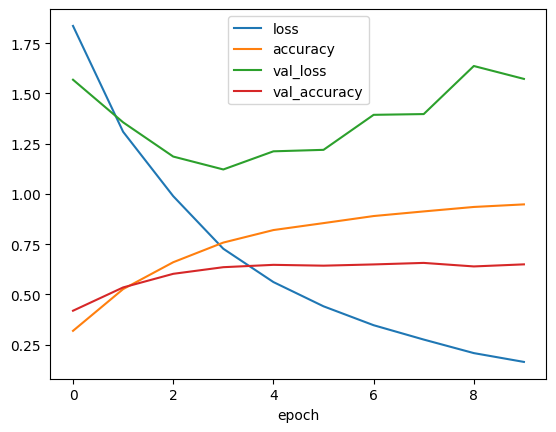

In [45]:
pd.DataFrame(history.history).plot(xlabel='epoch')

- RNN such as LSTM takes too long time
- epoch 3-4 is enough

In [46]:
## predict
y_pred = model.predict(X_test).argmax(axis=1)
y_pred = [index_2_label[i] for i in y_pred]

## print F1 scores
print(classification_report(y_test, y_pred))

81/81 [==============================] - 3s 30ms/step
               precision    recall  f1-score   support

        crime       0.59      0.63      0.61       304
      economy       0.65      0.62      0.63       181
    education       0.59      0.71      0.64       171
entertainment       0.66      0.62      0.64       144
      foreign       0.67      0.65      0.66       196
        local       0.34      0.37      0.36       283
     politics       0.82      0.79      0.81       492
    publicize       0.67      0.71      0.69       236
       region       0.51      0.42      0.46       377
        sport       0.88      0.90      0.89       183

     accuracy                           0.63      2567
    macro avg       0.64      0.64      0.64      2567
 weighted avg       0.64      0.63      0.63      2567



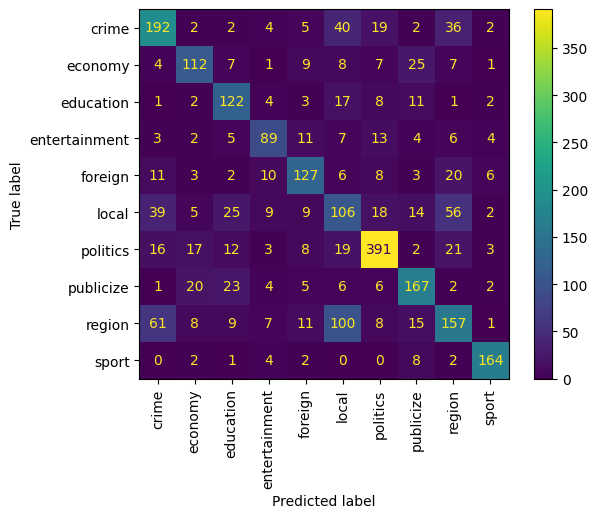

In [47]:
## print confusion matrix
labels = list(label_2_index.keys())

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=90)

- the result is not so different from logistic regression
- probably because, both logistic regression and NN use only bag-of-words features
- but, NN can get as high score as logistic regression by using only unigrams